# Interpreting the coefficients - global explanations

[Machine Learning Interpretability course](https://www.trainindata.com/p/machine-learning-interpretability)

In this notebook, we will interpret the values of the coefficients and how they affect the probability of the outcome.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

### Load data

To obtain the data, check the folder `prepare-data` in this repo, or section 2 in the course.

In [2]:
# load titanic dataset

df = pd.read_csv('../titanic.csv')

df.head()

,pclass,sibsp,parch,survived,sex_female,embarked_S,embarked_C,cabin_B,cabin_C,cabin_E,cabin_D,cabin_A,cabin_M,cabin_G
0,1,0,0,1,1,1,0,1,0,0,0,0,0,0
1,1,1,2,1,0,1,0,0,1,0,0,0,0,0
2,1,1,2,0,1,1,0,0,1,0,0,0,0,0
3,1,1,2,0,0,1,0,0,1,0,0,0,0,0
4,1,1,2,0,1,1,0,0,1,0,0,0,0,0


In [3]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("survived", axis=1),
    df["survived"],
    test_size=0.15,
    random_state=1,
)

X_train.shape, X_test.shape

((1112, 13), (197, 13))

In [4]:
# scale the variables
scaler = StandardScaler().set_output(transform="pandas")

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# display top 5 rows
X_train.head()

,pclass,sibsp,parch,sex_female,embarked_S,embarked_C,cabin_B,cabin_C,cabin_E,cabin_D,cabin_A,cabin_M,cabin_G
1021,0.834271,-0.474139,-0.456096,-0.739319,0.666450,-0.516251,-0.22592,-0.280294,-0.182913,-0.193167,-0.128271,0.539927,-0.067206
512,-0.367425,0.469050,-0.456096,-0.739319,-1.500487,1.937043,-0.22592,-0.280294,-0.182913,-0.193167,-0.128271,0.539927,-0.067206
957,0.834271,2.355428,0.745749,1.352596,0.666450,-0.516251,-0.22592,-0.280294,-0.182913,-0.193167,-0.128271,0.539927,-0.067206
1066,0.834271,-0.474139,-0.456096,-0.739319,-1.500487,1.937043,-0.22592,-0.280294,-0.182913,-0.193167,-0.128271,0.539927,-0.067206
1259,0.834271,-0.474139,-0.456096,-0.739319,0.666450,-0.516251,-0.22592,-0.280294,-0.182913,-0.193167,-0.128271,0.539927,-0.067206


In [5]:
# We know from previous notebooks that these features are non-
# predictive (their coefficients are not significantly
# different from 0.)

non_predictive = ["parch", "embarked_S", "embarked_C", "cabin_C",
                  "cabin_B", "cabin_E", "cabin_D", "cabin_A", "cabin_G"]

# So we take them out
X_train.drop(non_predictive, axis=1, inplace=True)
X_test.drop(non_predictive, axis=1, inplace=True)

## Statsmodels

In [6]:
# Our model needs an intercept so we add a column of 1s:

X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

In [7]:
# Fit logistic regression model

logit_mod = sm.Logit(y_train, X_train_sm)

logit_res = logit_mod.fit()

print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.478401
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                 1112
Model:                          Logit   Df Residuals:                     1107
Method:                           MLE   Df Model:                            4
Date:                Tue, 14 Nov 2023   Pseudo R-squ.:                  0.2788
Time:                        10:58:08   Log-Likelihood:                -531.98
converged:                       True   LL-Null:                       -737.67
Covariance Type:            nonrobust   LLR p-value:                 9.678e-88
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6454      0.078     -8.321      0.000      -0.797      -0.493
pclass        -0.4967      0.

**Note**: It is important to one hot encode into k-1 for logistic regression, otherwise the Logit from statsmodels will raise a convergence error, due to data redundancy.

## Odds ratio

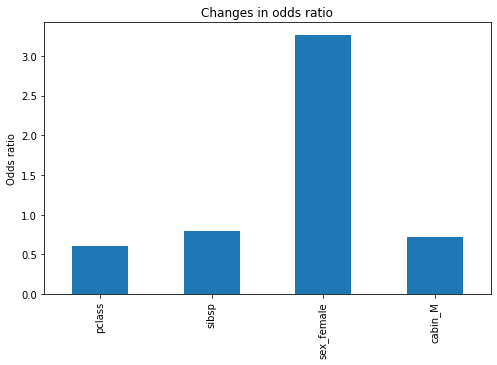

In [8]:
# Calculate and plot the odds ratio

s = pd.Series(
    np.exp(logit_res.params),
    index=X_train.columns,
)

s.plot.bar(figsize=(8,5))
plt.ylabel("Odds ratio")
plt.title("Changes in odds ratio")
plt.show()

Being female, increased the probability of survival 3 times.


The remaining variables reduced the probability of survival by ~half.

## Coefficient sign and direction

Visualize how the coefficients affect the probability of survival, and with the error, we know if we can trust them.

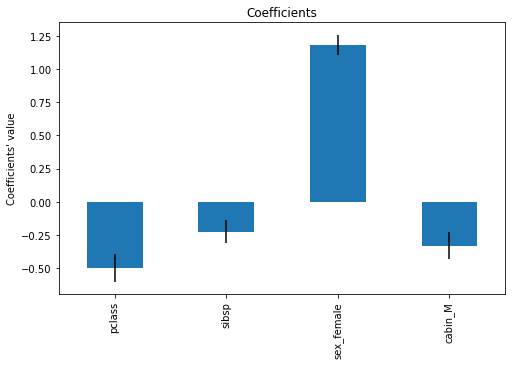

In [9]:
# Coefficients value

s = pd.Series(
    logit_res.params,
    index=X_train.columns,
)

s.plot.bar(yerr=logit_res.bse, figsize=(8,5))
plt.ylabel("Coefficients' value")
plt.title("Coefficients")
plt.show()

By looking at the coefficient sign and absolute magnitude we conclude that being female increases the probability of survival. 

Increasing the value of all other variables decreases the probability of survival.

The standard error among the coefficients is very similar.

## Coefficient absolute value - feature importance

This is what we normally use as a measure of feature importance.

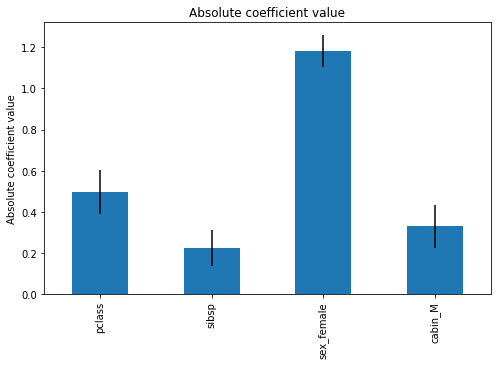

In [10]:
# Plot mean coefficient and std

s = pd.Series(
    np.abs(logit_res.params),
    index=X_train.columns,
)

s.plot.bar(yerr=logit_res.bse, figsize=(8,5))
plt.ylabel("Absolute coefficient value")
plt.title("Absolute coefficient value")
plt.show()

The most important feature is gender. The second most important variable is social status, indicated by the class in which the passenger was traveling (first class, second or third). 

## z (Wald statistic)

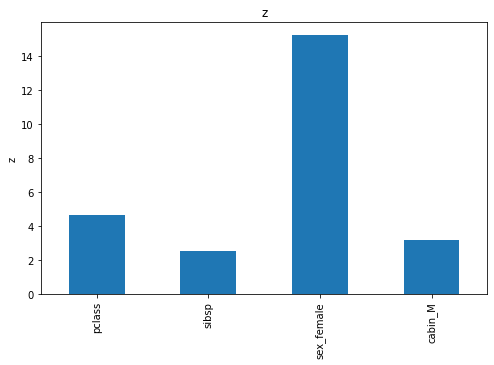

In [11]:
# estimate and plot z

s = pd.Series(
    np.abs(logit_res.tvalues),
    index=X_train.columns,
)

s.plot.bar(figsize=(8,5))
plt.ylabel("z")
plt.title("z")
plt.show()

The errors for all coefficients is very similar, so there are no surprises here when we plot the z score.

So by looking at the coefficients and the odds ratio, we now know that:

- females were 3 times more likely to survive than men.
- richer people (travelling in class 1) were more likely to survive than poorer people (pclass decreases probability of survival)
- having children or spouse (sibsp) also decreased, for some reason, the probability of survival.
- Not having data about in which cabin the passenger was traveling, is a poor indicator of survival as well.

The latter is probably a consequence of data collection. If the person did not survive, it is harder to obtain information about where they were traveling. So if this model was for real, probably we would not want to have that variable as input, because it was collected after it happened.